In [140]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import torch, os, sys
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

sys.path.append('../')
from utils.arg_parser import parse_exp_args

## Input fields

In [143]:
EXP_ID = 'vnn_delta_1'
figsize = (15,10)

In [47]:
def parse_loss_file(file):
    with open(file, 'r') as f:
        data = f.readlines()
    epochs = []
    losses = []
    for item in data:
        epoch, loss = tuple(item.strip().split(','))
        epochs.append(int(epoch))
        losses.append(float(loss))
    return np.array(epochs), np.array(losses)

In [48]:
log_dir = os.path.join('../','logs', EXP_ID)
train_loss_file = os.path.join(log_dir, 'train_loss.txt')
test_loss_file = os.path.join(log_dir, 'test_loss.txt')

In [49]:
train_ep, train_loss = parse_loss_file(train_loss_file)
test_ep, test_loss = parse_loss_file(test_loss_file)

## Plot loss curves

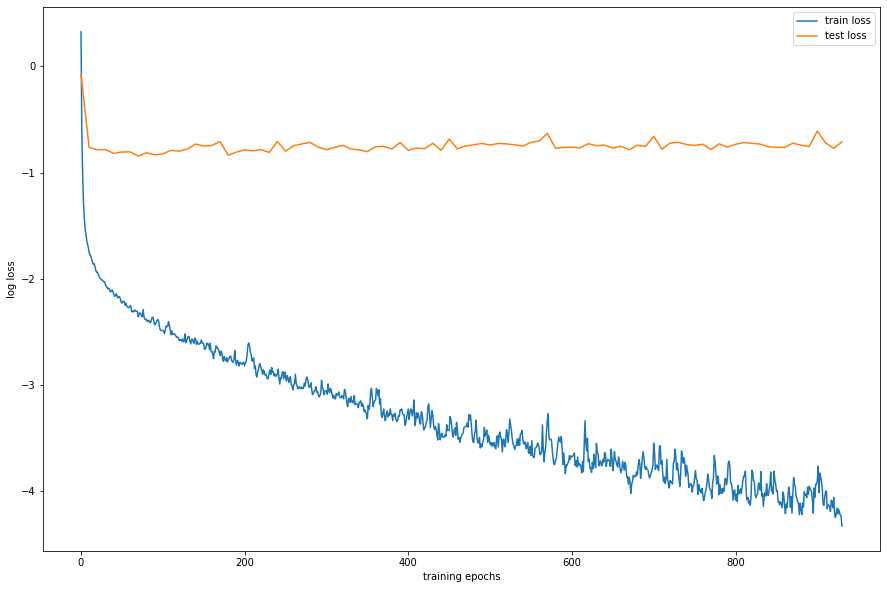

In [144]:
fig=plt.figure(figsize=figsize)
plt.plot(train_ep, np.log(train_loss), label='train loss')
plt.plot(test_ep, np.log(test_loss), label='test loss')
plt.xlabel('training epochs')
plt.ylabel('log loss')
plt.legend()
plt.show()

In [71]:
def get_best_model(log_dir, test_ep, test_loss):
    saved_models = []
    model_save_epochs = []
    for item in sorted(os.listdir(log_dir)):
        if'model_' in item:
            saved_models.append(item)
            ep = int(item.split('_')[-1])
            model_save_epochs.append(ep)
    model_save_epochs = sorted(model_save_epochs)
    loss_idxs = [list(test_ep.flatten()).index(x) for x in model_save_epochs]
    loss_idxs = sorted(loss_idxs)
    best_model_ep = model_save_epochs[np.argmin(test_loss[loss_idxs])]
    best_model_file = os.path.join(log_dir, 'model_ep_'+str(best_model_ep))
    assert os.path.exists(best_model_file)
    return best_model_file

In [91]:
best_model_file = get_best_model(log_dir, test_ep, test_loss)
loaded_state_dic = torch.load(best_model_file)

used_args_file = os.path.join(log_dir, 'args.txt')
args = parse_exp_args(used_args_file)
loaded_model = args.model(input_size=args.input_size, output_size=args.output_size,
                           actv_type=args.actv,
                           num_layers=args.num_layers,
                           hidden_size=args.hidden, 
                           bias=args.bias, 
                           use_bn=args.bn)

if 'module' in list(loaded_state_dic.keys())[0]:
    mod_state_dic = OrderedDict()
    for k,v in loaded_state_dic.items():
        mod_k = k.strip('module.')
        if mod_k not in loaded_model.state_dict():
            print('skipping {}'.format(mod_k))
            continue
        mod_state_dic[mod_k] = loaded_state_dic[k]

loaded_model.load_state_dict(mod_state_dic)

skipping fcs.0.bn.num_batches_track
skipping fcs.1.bn.num_batches_track
skipping fcs.2.bn.num_batches_track
skipping fcs.3.bn.num_batches_track
skipping fcs.4.bn.num_batches_track


<All keys matched successfully>

In [157]:
data_used_dir = os.path.join('../data/', args.dataset)
train_X = np.load(os.path.join(data_used_dir, 'train_X.npy')) 
train_y = np.load(os.path.join(data_used_dir, 'train_y.npy')) 
test_X = np.load(os.path.join(data_used_dir, 'test_X.npy')) 
test_y = np.load(os.path.join(data_used_dir, 'test_y.npy')) 
loaded_model.eval()

vanilla_nn(
  (loss): MSELoss()
  (fcs): ModuleList(
    (0): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (1): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (2): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (3): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (4): LinearLayer(
      (bn): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (5): LinearLayer()
  )
)

In [158]:
train_y_order = np.argsort(train_y.flatten())
test_y_order = np.argsort(test_y.flatten())

In [159]:
sorted_train_X = train_X[train_y_order]
sorted_train_y = train_y[train_y_order]
sorted_test_X = test_X[test_y_order]
sorted_test_y = test_y[test_y_order]

In [160]:
train_samp = sorted(np.random.choice(train_y.shape[0], size=test_y.shape[0], replace=False))

In [161]:
with torch.no_grad():
    train_pred = loaded_model(torch.FloatTensor(sorted_train_X[train_samp]))
    test_pred = loaded_model(torch.FloatTensor(sorted_test_X))

## Training predictions vs training labels

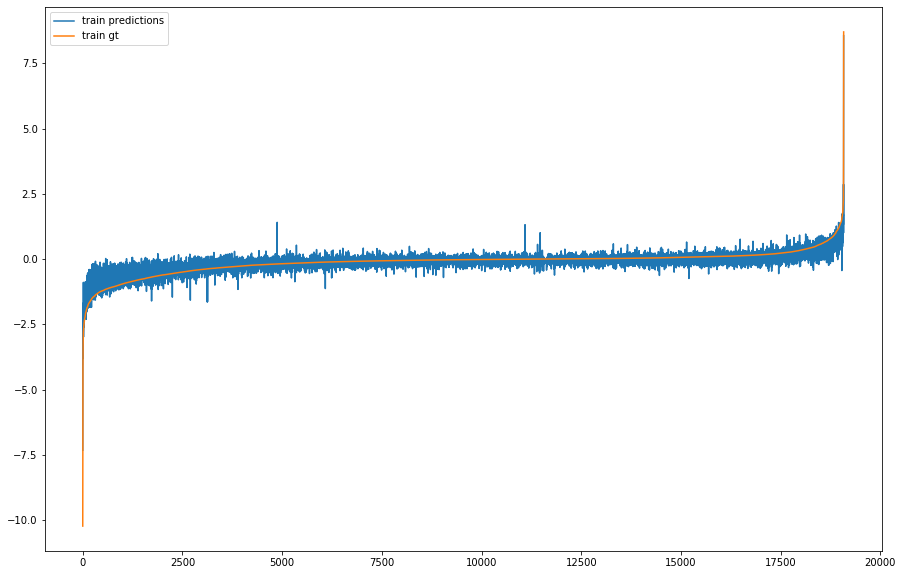

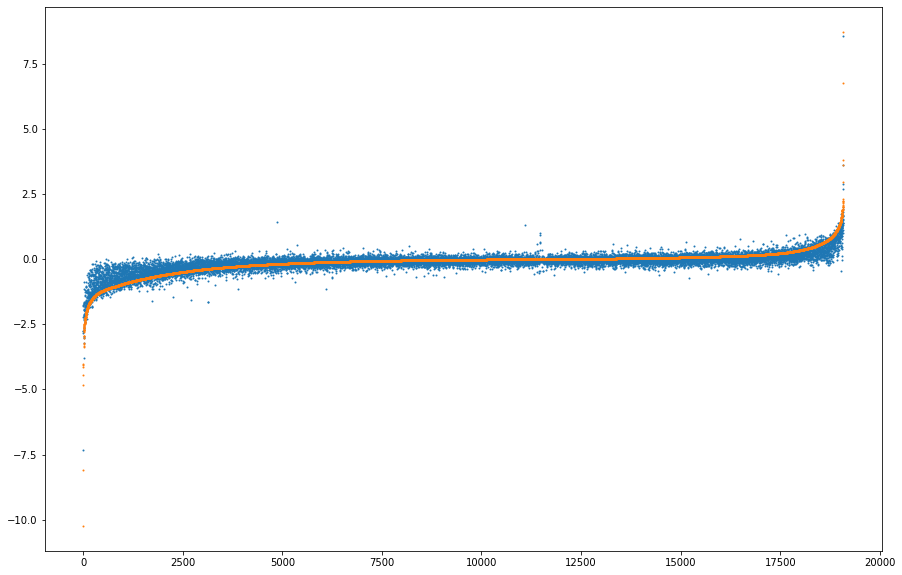

Train MSE 0.0496


In [162]:
fig = plt.figure(figsize=figsize)
plt.plot(train_pred.detach(), label='train predictions' )
plt.plot(sorted_train_y[train_samp], label='train gt')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize)
plt.scatter(np.arange(train_pred.shape[0]), train_pred.detach(), label='train predictions', s=1)
plt.scatter(np.arange(sorted_train_y[train_samp].shape[0]), sorted_train_y[train_samp], label='train gt', s=1)
plt.show()

## Testing predictions vs training labels

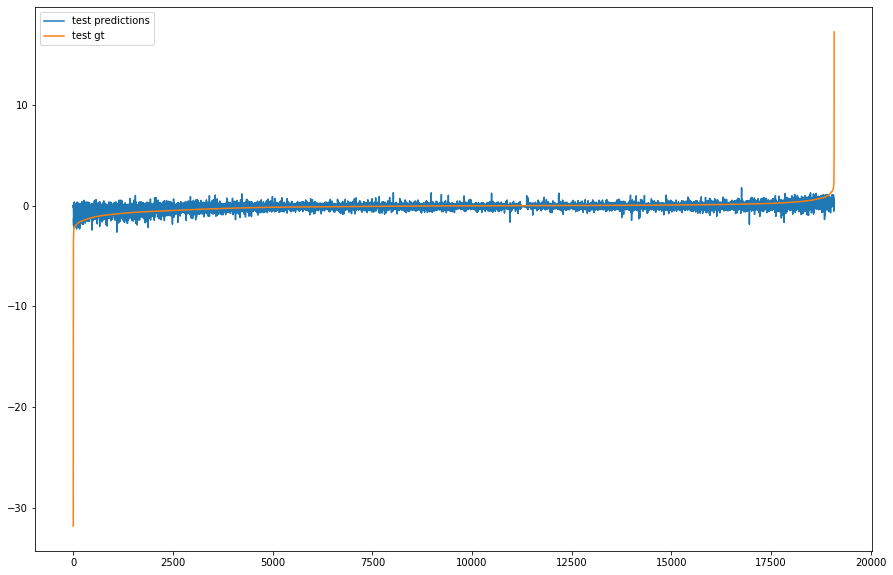

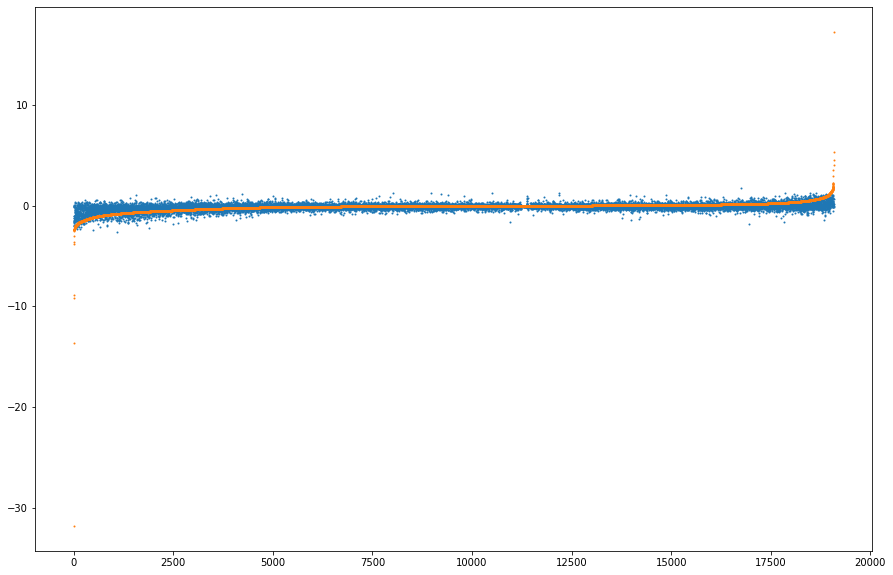

Test MSE 0.2208


In [163]:
fig = plt.figure(figsize=figsize)
plt.plot(test_pred.detach(), label='test predictions' )
plt.plot(sorted_test_y, label='test gt')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize)
plt.scatter(np.arange(test_pred.shape[0]), test_pred.detach(), label='test predictions', s=1)
plt.scatter(np.arange(sorted_test_y.shape[0]), sorted_test_y, label='test gt', s=1)
plt.show()

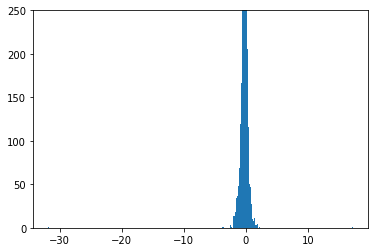

In [176]:
# fig = plt.figure(figsize=figsize)
plt.hist(sorted_test_y.flatten(), bins = 1000, label='test gt')
plt.ylim(0,250)
# plt.hist(test_pred.numpy().flatten(), label='test pred')
plt.show()

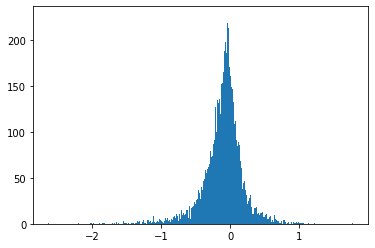

In [174]:
plt.hist(test_pred.numpy().flatten(), bins=1000, label='test pred')
plt.show()

In [184]:
train_MSE = np.mean((train_pred.detach().numpy() - sorted_train_y[train_samp])**2)
test_MSE = np.mean((test_pred.detach().numpy() - sorted_test_y)**2)
print('Train MSE {0:.4f}'.format(train_MSE))
print('Test MSE {0:.4f}'.format(test_MSE))

Train MSE 0.0496
Test MSE 0.2208


In [185]:
print('Predicted test mean {0:.4f}'.format(np.mean(test_pred.detach().numpy())))
print('GT test mean {0:.4f}'.format(np.mean(sorted_test_y)))

Predicted test mean -0.1055
GT test mean -0.1058


In [186]:
print('Predict 0 delta betan {0:.4f}'.format(np.mean(sorted_test_y**2)))
print('Predict mean of GT delta betan {0:.4f}'.format(np.mean((sorted_test_y - np.mean(sorted_test_y))**2)))
print('Predict mean of predicted delta betan {0:.4f}'.format(np.mean((sorted_test_y - np.mean(test_pred.detach().numpy()))**2)))

Predict 0 delta betan 0.2625
Predict mean of GT delta betan 0.2513
Predict mean of predicted delta betan 0.2513
